# Pre-Processing Data

This notebook should get all the relevant data, convert it into data of the same size and then save this new data. If a piece of data has enough data to be converted into many data points, it should be.

In [3]:
import os
from pathlib import Path
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# From Joao Maio on Piazza
target_folder = Path('.')/'..'/'pdiot-data'/'2020'

student_pattern = "s\d{7}"

files = {}
for (dirpath, dirnames, filenames) in os.walk(target_folder):
  s_match = re.search(student_pattern, dirpath)
  # if regex matches, and files exist
  if s_match and filenames:
    s = s_match.group()
    #print(f"adding files for {s} (in {dirpath})")
    dir = Path(dirpath)
    try: files[s]
    except KeyError: files[s] = []
    # only accept .csv files
    files[s].extend([dir/f for f in filenames if f[-4:] == '.csv'])

print("File count:")
print({k: len(v) for (k, v) in files.items()})

File count:
{'s1621503': 84, 's1746788': 84, 's1701688': 84, 's1735229': 84, 's1710228': 84, 's1737472': 78, 's1704037': 79, 's2017768': 87, 's1768094': 225, 's1770036': 78, 's1721039': 81, 's1616573': 112, 's1709221': 78, 's1655560': 78, 's1711507': 236, 's1655552': 90, 's1764751': 92, 's1707651': 65, 's1642301': 84, 's1751093': 79, 's2124639': 89, 's1758009': 84, 's1758499': 84, 's1660711': 84, 's1736273': 84}


In [4]:
def get_random_student(students):
    return np.random.choice(students)


In [5]:
activity_dict = {
    0: "Sitting",
    4: "Sitting bent forward",
    5: "Sitting bent backward",
    1: "Walking at normal speed",
    100: "Standing",
    2: "Lying down on back",
    7: "Lying down left",
    6: "Lying down right",
    8: "Lying down on stomach",
    9: "Movement",
    11: "Running",
    12: "Climbing stairs",
    13: "Descending stairs",
    31: "Desk work"}

In [6]:
# From Teodora Georgescu on Piazza
def read_old_file_format(file_path):
    """
    Reads the recording files that do not contain headers.
    """
    pdiot_data = pd.read_csv(file_path)
    
    ACTIVITY_CODE_TO_NAME_MAPPING = {
        0: "Sitting",
        4: "Sitting bent forward",
        5: "Sitting bent backward",
        1: "Walking at normal speed",
        100: "Standing",
        2: "Lying down on back",
        7: "Lying down left",
        6: "Lying down right",
        8: "Lying down on stomach",
        9: "Movement",
        11: "Running",
        12: "Climbing stairs",
        13: "Descending stairs",
        31: "Desk work"}
    
    pdiot_header_information = dict()
    pdiot_header_information["Sensor position"] = pdiot_data['sensor_position'].values[0]
    pdiot_header_information["Sensor side"] = pdiot_data['sensor_side'].values[0]
    pdiot_header_information["Activity type"] = ACTIVITY_CODE_TO_NAME_MAPPING[pdiot_data['activity_type'].values[0]]
    pdiot_header_information["Activity code"] = pdiot_data['activity_type'].values[0]
    pdiot_header_information["Subject id"] = pdiot_data['subject_id'].values[0]
    
    pdiot_data.drop(columns=['sensor_position','sensor_side', 'subject_id', 'activity_type', 'recording_id'], inplace=True)
    
    return pdiot_data, pdiot_header_information

In [7]:
# Change depending on what sensor position you want.
def get_data(desired_position):
    desired = []
    for student in files:
        desired = desired + ([f for f in files[student] if desired_position in str(f)])
    len(desired)

    header_size = 5
    data = []
    for d in desired:
        read = pd.read_csv(d, skiprows=5)
        if 'timestamp' not in read.columns:
            read, head = read_old_file_format(d)
        else:
            with open(d) as f:
                head = [next(f).rstrip().split('# ')[1] for x in range(header_size)]
        data.append((head,read))
    return data


In [8]:
def get_seconds(data):
    ts = data[1]['timestamp']
    start = ts[0]
    end = ts[len(ts)-1]
    return (end-start) / 1000, start, end
    

In [9]:
def get_data_by_time(data,time_wanted):
    #time_wanted = 20
    new_data = []
    for d in data:
        main = d[1]
        if len(main) == 0:
            continue
        time, start, end = get_seconds(d)
        if time >= time_wanted + 2:
            # print(get_seconds(d))
            # shave of first and last second
            start = start + 1000
            end = end - 1000
            mask = (main['timestamp'] >= start) & (main['timestamp'] <= end)
            main = main[mask]
            repeats = time / time_wanted
            for r in range(int(repeats)):
                seconds = time_wanted * 1000
                intstart = start + (seconds * r)
                intend = intstart + seconds
                #print((intend-intstart)/1000)
                #print("r", r)
                #print("s", start) 
                #print("e", intend)
                mask = (main['timestamp'] >= intstart) & (main['timestamp'] <= intend)
                new = main[mask].reset_index(drop=True)
                #print(new)
                new_data.append((list(d[0]), new))
    return new_data


In [15]:
data = get_data("Chest_Left")
time_data = get_data_by_time(data, 2)

In [16]:
sitting = [{'data': d[1].filter(['accel_x','accel_y','accel_z']), 'target': int(d[0][3].split(':')[1])} for d in time_data if "Sitting" in d[0][2] ]
walking = [{'data': d[1].filter(['accel_x','accel_y','accel_z']), 'target': int(d[0][3].split(':')[1])} for d in time_data if "Walking" in d[0][2] and d[1].shape[0]<500 and d[1].shape[0]>0]
standing = [{'data': d[1].filter(['accel_x','accel_y','accel_z']), 'target': int(d[0][3].split(':')[1])} for d in time_data if "Standing" in d[0][2] and d[1].shape[0]<500 and d[1].shape[0]>0]
lying = [{'data': d[1].filter(['accel_x','accel_y','accel_z']), 'target': int(d[0][3].split(':')[1])} for d in time_data if "Lying" in d[0][2] and d[1].shape[0]<500 and d[1].shape[0]>0]
movement = [{'data': d[1].filter(['accel_x','accel_y','accel_z']), 'target': int(d[0][3].split(':')[1])} for d in time_data if "Movement" in d[0][2] and d[1].shape[0]<500 and d[1].shape[0]>0]
running = [{'data': d[1].filter(['accel_x','accel_y','accel_z']), 'target': int(d[0][3].split(':')[1])} for d in time_data if "Running" in d[0][2] and d[1].shape[0]<500 and d[1].shape[0]>0]
climb_stairs = [{'data': d[1].filter(['accel_x','accel_y','accel_z']), 'target': int(d[0][3].split(':')[1])} for d in time_data if "Climbing stairs" in d[0][2] and d[1].shape[0]<500 and d[1].shape[0]>0]
descend_stairs = [{'data': d[1].filter(['accel_x','accel_y','accel_z']), 'target': int(d[0][3].split(':')[1])} for d in time_data if "Descending stairs" in d[0][2] and d[1].shape[0]<500 and d[1].shape[0]>0]
desk_work = [{'data': d[1].filter(['accel_x','accel_y','accel_z']), 'target': int(d[0][3].split(':')[1])} for d in time_data if "Desk work" in d[0][2] and d[1].shape[0]<500 and d[1].shape[0]>0]

In [17]:
len(sitting)

1257

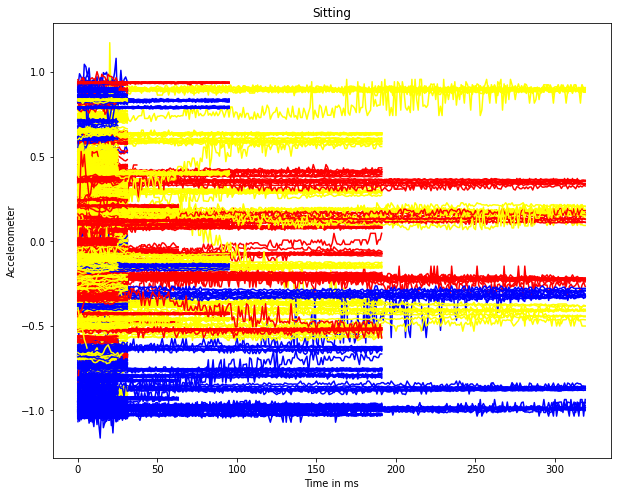

In [18]:
fig = plt.figure(figsize=(10, 8))

for s in sitting:    
    plt.plot(s['data']['accel_x'],c='red')
    plt.plot(s['data']['accel_y'],c='blue')
    plt.plot(s['data']['accel_z'],c='yellow')

plt.xlabel("Time in ms")
plt.ylabel("Accelerometer")
plt.title("Sitting")

plt.savefig("time_pre_processing",facecolor='white')

In [19]:
shapes = []
for d in desk_work:
    shapes.append(d['data'].shape[0])
print(shapes)

[25, 20, 25, 25, 25, 26, 25, 26, 23, 21, 25, 25, 26, 25, 16, 146, 160, 160, 116, 44, 160, 160, 160, 160, 160, 160, 15, 145, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 26, 25, 25, 26, 25, 26, 25, 25, 26, 25, 26, 25, 25, 26, 23, 21, 25, 26, 26, 25, 26, 25, 25, 26, 25, 26, 25, 25, 6, 26, 25, 25, 26, 25, 26, 25, 25, 26, 25, 26, 25, 25, 26, 25, 26, 25, 25, 26, 25, 26, 25, 25, 26, 25, 26, 25, 25, 26, 5, 26, 25, 25, 26, 25, 25, 22, 25, 25, 26, 25, 25, 26, 25, 26, 25, 21, 26, 25, 25, 26, 25, 26, 25, 25, 26, 25, 26, 25, 22, 23, 26, 25, 21, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 64, 64, 64, 64, 34, 30, 64, 64, 64, 64, 64, 64, 32, 32, 32, 32, 24, 8, 32, 32, 32, 32, 32, 26, 25, 25, 26, 25, 26, 25, 25, 23, 23, 25, 25, 26, 25, 26, 25, 25, 23, 23, 25, 25, 26, 25, 26, 25, 25, 23, 20, 

In [106]:
def get_data_by_datapoints(data, points_wanted=50, overlap=0.5):
    new_data = []
    new_targets = []
    students = []
    for d in data:
        main = d[1].reset_index(drop=True)
        if len(d[1]) == 0:
            continue
        if type(d[0]) != dict:
            target = int(d[0][3].split(':')[1])
            student = d[0][4].split(':')[1].strip()
        else:
            target = d[0]["Activity code"]
            student = d[0]["Subject id"]
        # Shave of first and last second
        start = 13
        end = len(main) - 1 - 13
        main = main[start:end].reset_index(drop=True)
        iters = main.shape[0] / points_wanted
        start = 0
        end = points_wanted
        for i in range(int(iters/overlap)-1):
            s_data = main[start:end].filter(['accel_x','accel_y','accel_z']).reset_index(drop=True)
            s_data = np.append( np.append(np.array(s_data['accel_x']).flatten(), np.array(s_data['accel_y']).flatten()), np.array(s_data['accel_z']).flatten() )
            
            new_data.append(s_data)
            
            new_targets.append(target)
            students.append(student.lower())
            start += int(points_wanted * overlap)
            end = int(start + points_wanted)
    
    return np.array(new_data), np.array(new_targets), np.array(students)

In [107]:
data = get_data("Chest_Left")
cleaned_data, targets, students = get_data_by_datapoints(data, points_wanted = 50, overlap=0.5)

In [115]:
cleaned_data[0]

array([-0.57788086, -0.57836914, -0.5744629 , -0.57299805, -0.5698242 ,
       -0.564209  , -0.56347656, -0.5637207 , -0.5620117 , -0.5632324 ,
       -0.5563965 , -0.5476074 , -0.5437012 , -0.5341797 , -0.5300293 ,
       -0.5275879 , -0.5263672 , -0.52978516, -0.53027344, -0.53100586,
       -0.5280762 , -0.5275879 , -0.52905273, -0.5300293 , -0.532959  ,
       -0.54248047, -0.548584  , -0.55029297, -0.5559082 , -0.55810547,
       -0.5588379 , -0.5620117 , -0.56030273, -0.5563965 , -0.55493164,
       -0.5488281 , -0.5419922 , -0.53881836, -0.5397949 , -0.54418945,
       -0.55126953, -0.5595703 , -0.5620117 , -0.5625    , -0.5654297 ,
       -0.56640625, -0.5617676 , -0.55981445, -0.55200195, -0.54345703,
       -0.06134033, -0.0647583 , -0.06085205, -0.06402588, -0.06231689,
       -0.06280518, -0.05718994, -0.04888916, -0.04669189, -0.04937744,
       -0.05133057, -0.05157471, -0.04888916, -0.04986572, -0.05133057,
       -0.04864502, -0.04693604, -0.04840088, -0.04400635, -0.04

In [40]:
for k,v in activity_dict.items():
    print("{:<25} {} ".format(v, len(cleaned_data[targets==k])))
print(len(activity_dict))

Sitting                   829 
Sitting bent forward      736 
Sitting bent backward     682 
Walking at normal speed   782 
Standing                  716 
Lying down on back        789 
Lying down left           750 
Lying down right          671 
Lying down on stomach     730 
Movement                  536 
Running                   664 
Climbing stairs           585 
Descending stairs         556 
Desk work                 796 
14


## ML Methods

In [840]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

In [841]:
c_new = [p.flatten() for p in c]

In [804]:
X_train, X_test, y_train, y_test = train_test_split(c_new, n, test_size=0.33, random_state=42)
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
knn.score(X_test, y_test)

0.7256894049346879

## Finding K

In [789]:
scores = []
for k in range(1,100):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    score = knn.score(X_test, y_test)
    scores.append(score)

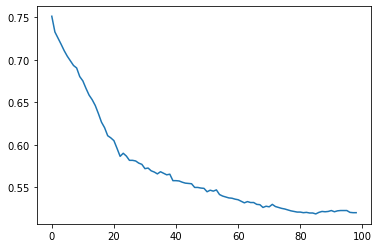

In [793]:
plt.plot(scores)

In [901]:
np.max(scores)

0.7514513788098693

In [812]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)
y_preds = knn.predict(X_test)

In [806]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

(<Figure size 1008x1008 with 1 Axes>,
 <AxesSubplot:xlabel='predicted label', ylabel='true label'>)

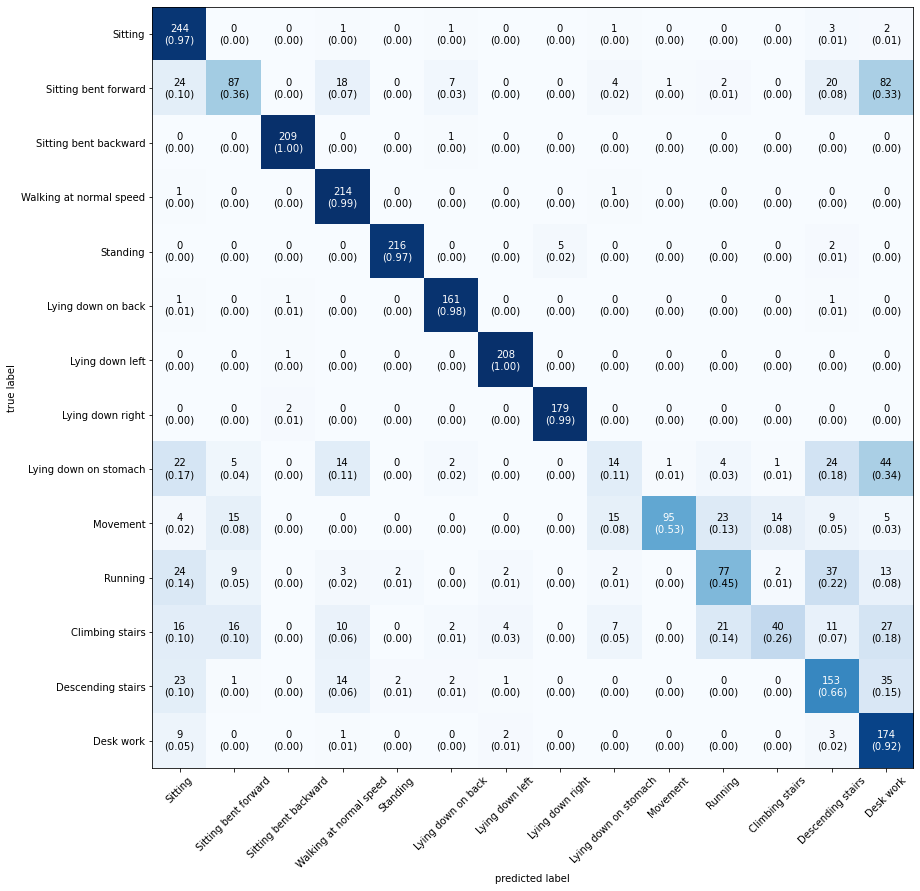

In [817]:
mat = confusion_matrix(y_test, y_preds)
plot_confusion_matrix(conf_mat=mat, class_names=activity_dict.values(), show_normed=True, figsize=(14,14))

In [47]:
from sklearn.ensemble import RandomForestClassifier

In [923]:
X_train, X_test, y_train, y_test = train_test_split(c_new, n, test_size=0.33)

In [924]:
clf = RandomForestClassifier(random_state=0)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

In [925]:
clf.score(X_test, y_test)

0.8534107402031931

In [926]:
y_preds = clf.predict(X_test)

In [927]:
y_preds

array([  2,  12,   0, ...,  11,   1, 100])

(<Figure size 1008x1008 with 1 Axes>,
 <AxesSubplot:xlabel='predicted label', ylabel='true label'>)

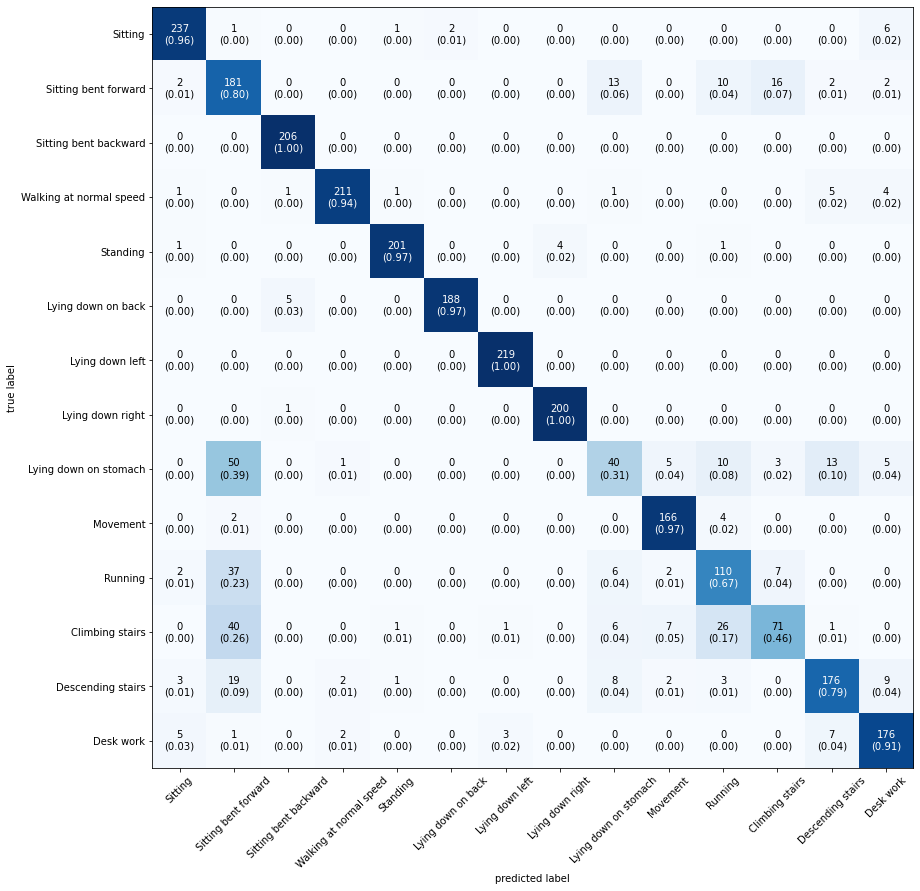

In [852]:
mat = confusion_matrix(y_test, y_preds)
plot_confusion_matrix(conf_mat=mat, class_names=activity_dict.values(), show_normed=True, figsize=(14,14))

Text(0.5, 1.0, 'Sitting')

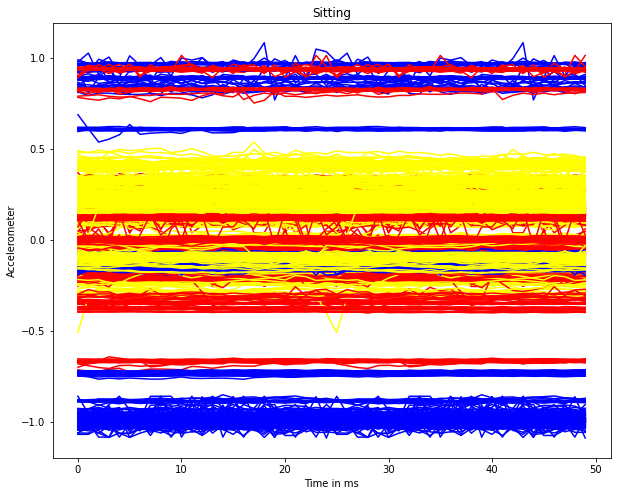

In [118]:
fig = plt.figure(figsize=(10, 8))

mask = cleaned_data[targets == 0]

for p in mask:
    plt.plot(p[0:50],c='red')
    plt.plot(p[50:100],c='blue')
    plt.plot(p[100:150],c='yellow')

plt.xlabel("Time in ms")
plt.ylabel("Accelerometer")
plt.title("Sitting")

#plt.savefig("datapoints_pre_processing",facecolor='white')

## Finding number of trees

In [933]:
scores = []
for x in range(50,150,10):
    clf = RandomForestClassifier(n_estimators = x, random_state=0)
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    print(x, score)
    scores.append((x, score))

50 0.8486937590711175
60 0.8486937590711175
70 0.8476052249637155
80 0.8530478955007257
90 0.852322206095791
100 0.8534107402031931
110 0.8552249637155298
120 0.8537735849056604
130 0.8541364296081277
140 0.854499274310595


In [940]:
for x in range(150,200,10):
    clf = RandomForestClassifier(n_estimators = x, random_state=0)
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    print(x, score)
    scores.append((x, score))

150 0.8548621190130624
160 0.8555878084179971
170 0.8534107402031931
180 0.8530478955007257
190 0.8548621190130624


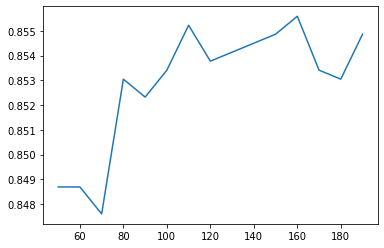

In [969]:
x = [s[0] for s in scores]
y = [s[1] for s in scores]
plt.plot(x,y)

In [972]:
x

[50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190]

## Finding max_depth

In [949]:
max_depths = np.linspace(1, 32, 32, endpoint=True)
depth_scores = []
for m in max_depths:
    clf = RandomForestClassifier(max_depth = m, random_state=0)
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    print(m, score)
    depth_scores.append((m, score))

1.0 0.2677793904208999
2.0 0.32946298984034833
3.0 0.38243831640058057
4.0 0.45428156748911463
5.0 0.5671262699564587
6.0 0.6026850507982583
7.0 0.6607402031930334
8.0 0.6944847605224964
9.0 0.7155297532656023
10.0 0.7481857764876633
11.0 0.7681422351233672
12.0 0.7989840348330914
13.0 0.8087808417997098
14.0 0.8232946298984035
15.0 0.8338171262699564
16.0 0.8428882438316401
17.0 0.8410740203193033
18.0 0.8483309143686503
19.0 0.8486937590711175
20.0 0.8515965166908563
21.0 0.8497822931785196
22.0 0.8505079825834543
23.0 0.852322206095791
24.0 0.8508708272859217
25.0 0.851233671988389
26.0 0.8515965166908563
27.0 0.8519593613933236
28.0 0.8515965166908563
29.0 0.8534107402031931
30.0 0.8534107402031931
31.0 0.8534107402031931
32.0 0.852322206095791


In [ ]:
max_depths = np.linspace(32, 64, 32, endpoint=True)
for m in max_depths:
    clf = RandomForestClassifier(max_depth = m, random_state=0)
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    print(m, score)
    depth_scores.append((m, score))

(29, 0.8534107402031931)

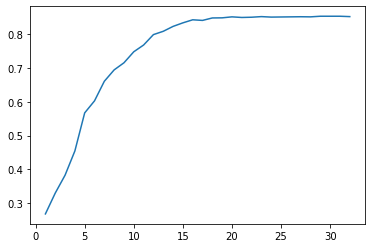

In [963]:
d_x = [d[0] for d in depth_scores]
d_y = [d[1] for d in depth_scores]
plt.plot(d_x, d_y)
depth_scores[np.argmax(d_y)]

In [974]:
clf = RandomForestClassifier(max_depth = 29, n_estimators = 160, random_state=0)
clf.fit(X_train, y_train)
score = clf.score(X_test, y_test)
print(score)

0.8552249637155298


In [975]:
clf = RandomForestClassifier(random_state=0)
clf.fit(X_train, y_train)
score = clf.score(X_test, y_test)
print(score)

0.8534107402031931


In [987]:
clf = RandomForestClassifier(max_depth = 29, n_estimators = 160, random_state=0, min_samples_split=2)
clf.fit(X_train, y_train)
score = clf.score(X_test, y_test)
print(score)

0.8552249637155298


In [994]:
clf = RandomForestClassifier(max_depth = 29, n_estimators = 160, random_state=0, min_samples_leaf=1)
clf.fit(X_train, y_train)
score = clf.score(X_test, y_test)
print(score)

0.8552249637155298


## Try with reduced classes

In [1078]:
new_data = c.copy()
new_targets = n.copy()
activity_dict

{0: 'Sitting',
 4: 'Sitting bent forward',
 5: 'Sitting bent backward',
 1: 'Walking at normal speed',
 100: 'Standing',
 2: 'Lying down on back',
 7: 'Lying down left',
 6: 'Lying down right',
 8: 'Lying down on stomach',
 9: 'Movement',
 11: 'Running',
 12: 'Climbing stairs',
 13: 'Descending stairs',
 31: 'Desk work'}

In [1079]:
# Convert sitting
mask = new_targets == 4
mask1 = new_targets == 5
mask = mask | mask1
new_targets[mask] = 0

In [1080]:
# Convert lying
mask = new_targets == 7
mask1 = new_targets == 6
mask2 = new_targets == 8
mask = mask | mask1 | mask2
new_targets[mask] = 2

In [1081]:
# Remove movement
mask = new_targets == 9

In [1091]:
new_data = np.array([p.flatten() for p in new_data])

In [1110]:
new_data = np.delete(new_data,mask,axis =0)

In [1111]:
new_targets = np.delete(new_targets, mask)

In [1115]:
for k,v in activity_dict.items():
    print("{:<25} {} ".format(v, len(new_data[new_targets==k])))
print(len(activity_dict))

Sitting                   1988 
Sitting bent forward      0 
Sitting bent backward     0 
Walking at normal speed   705 
Standing                  603 
Lying down on back        2499 
Lying down left           0 
Lying down right          0 
Lying down on stomach     0 
Movement                  0 
Running                   547 
Climbing stairs           500 
Descending stairs         473 
Desk work                 631 
14


In [1116]:
new_activity_dict = activity_dict

In [1134]:
new_activity_dict = {0: 'Sitting',
 1: 'Walking',
 100: 'Standing',
 2: 'Lying down',
 11: 'Running',
 12: 'Climbing stairs',
 13: 'Descending stairs',
 31: 'Desk work'}

In [1135]:
new_activity_dict

{0: 'Sitting',
 1: 'Walking',
 100: 'Standing',
 2: 'Lying down',
 11: 'Running',
 12: 'Climbing stairs',
 13: 'Descending stairs',
 31: 'Desk work'}

In [1136]:
for k,v in new_activity_dict.items():
    print("{:<25} {} ".format(v, len(new_data[new_targets==k])))
print(len(activity_dict))

Sitting                   1988 
Walking                   705 
Standing                  603 
Lying down                2499 
Running                   547 
Climbing stairs           500 
Descending stairs         473 
Desk work                 631 
8


In [1137]:
X_train, X_test, y_train, y_test = train_test_split(new_data, new_targets, test_size=0.33)

In [1139]:
clf = RandomForestClassifier(random_state = 0)
clf.fit(X_train, y_train)
score = clf.score(X_test, y_test)
print(score)

0.8749523446435379


(<Figure size 1008x1008 with 1 Axes>,
 <AxesSubplot:xlabel='predicted label', ylabel='true label'>)

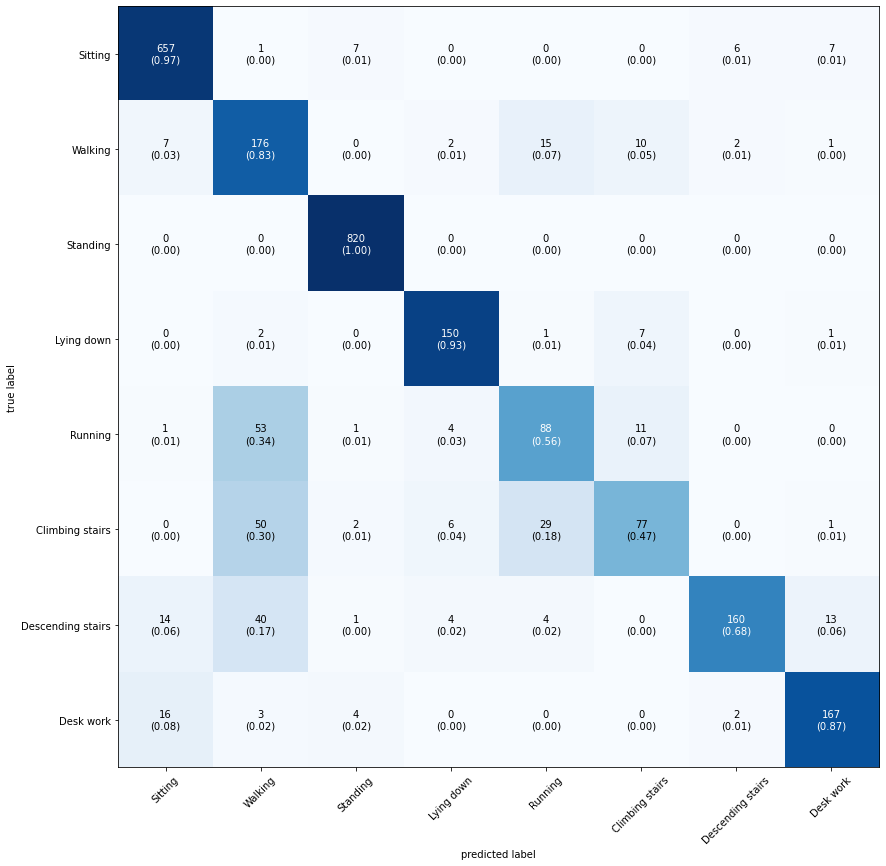

In [1140]:
y_preds = clf.predict(X_test)

y_preds

mat = confusion_matrix(y_test, y_preds)
plot_confusion_matrix(conf_mat=mat, class_names=new_activity_dict.values(), show_normed=True, figsize=(14,14))

Decision is to keep all classes

## LEAVE ONE OUT 

In [119]:
def leave_one_out(cleaned_data, targets, students, no_students = 1):
    un = np.unique(students)
    un = un[un != ""]
    random_student = get_random_student(un)
    
    student_data = cleaned_data[students == random_student]
    student_targets = targets[students == random_student]
    
    cleaned_data = cleaned_data[students != random_student]
    targets = targets[students != random_student]
    
    return cleaned_data, targets, student_data, student_targets

In [120]:
data = get_data("Chest_Left")
data, targets, students = get_data_by_datapoints(data, points_wanted = 50, overlap=0.5)

In [121]:
cleaned_data, targets, student_data, student_targets = leave_one_out(data, targets, students)

In [122]:
clf = RandomForestClassifier()
clf.fit(cleaned_data, targets)
score = clf.score(student_data, student_targets)
print(score)

0.6808510638297872


In [125]:
# Check if depth of tree makes a difference
max_depths = np.linspace(1, 32, 32, endpoint=True)
depth_scores = []
for m in max_depths:
    clf = RandomForestClassifier(max_depth = m)
    clf.fit(cleaned_data, targets)
    score = clf.score(student_data, student_targets)
    print(m, score)
    depth_scores.append((m, score))

1.0 0.2978723404255319
2.0 0.4326241134751773
3.0 0.41134751773049644
4.0 0.3971631205673759
5.0 0.475177304964539
6.0 0.49645390070921985
7.0 0.5319148936170213
8.0 0.5673758865248227
9.0 0.624113475177305
10.0 0.6382978723404256
11.0 0.6453900709219859
12.0 0.6524822695035462
13.0 0.6879432624113475
14.0 0.6808510638297872
15.0 0.6737588652482269
16.0 0.6950354609929078
17.0 0.6595744680851063
18.0 0.6808510638297872
19.0 0.6737588652482269
20.0 0.6737588652482269
21.0 0.6808510638297872
22.0 0.7092198581560284
23.0 0.6879432624113475
24.0 0.6879432624113475
25.0 0.7021276595744681
26.0 0.7021276595744681
27.0 0.6879432624113475
28.0 0.6950354609929078
29.0 0.6808510638297872
30.0 0.6950354609929078
31.0 0.6879432624113475
32.0 0.6737588652482269


In [126]:
# Check if number of estimators makes a difference (number of trees)
scores = []
for x in range(50,200,10):
    clf = RandomForestClassifier(n_estimators = x, max_depth = 22)
    clf.fit(cleaned_data, targets)
    score = clf.score(student_data, student_targets)
    print(x, score)
    scores.append((x, score))

50 0.7021276595744681
60 0.6808510638297872
70 0.6950354609929078
80 0.6950354609929078
90 0.6808510638297872
100 0.6879432624113475
110 0.6808510638297872
120 0.7021276595744681
130 0.723404255319149
140 0.6808510638297872
150 0.6879432624113475
160 0.6808510638297872
170 0.7021276595744681
180 0.6808510638297872
190 0.6879432624113475


In [130]:
clf = RandomForestClassifier(n_estimators = 130, max_depth = 22)
clf.fit(cleaned_data, targets)
score = clf.score(student_data, student_targets)

In [131]:
print(score)

0.7021276595744681
